In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from itertools import product as cartessian_product
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import RandomizedSearchCV

def hex_to_rgb(h):
    h = h.lstrip('#')
    return tuple(int(h[i:i+2], 16)/255 for i in (0, 2, 4))

cluster_colors_hex = ['#b4d2b1', '#568f8b', '#1d4a60', '#cd7e59', '#ddb247', '#d15252']
cluster_colors_rgb = [hex_to_rgb(x) for x in cluster_colors_hex]

custom_params = {
    "axes.spines.right":False,
    "axes.spines.top":False,
    'grid.alpha':0.3,
    'figure.figsize': (16, 6),
    'axes.titlesize': 'Large',
    'axes.labelsize':'Large',
    'figure.facecolor':'#fdfcf6',
    'axes.facecolor':'#fdfcf6'
}

sns.set_theme(
    style='whitegrid',
    palette=sns.color_palette(cluster_colors_hex),
    rc=custom_params
)

In [2]:
train_df = pd.read_csv('train.csv', parse_dates=['date'], index_col=0)
test_df = pd.read_csv('test.csv', parse_dates=['date'], index_col=0)

#### We check that no date is missing from train and test

In [3]:
missing_train = pd.date_range(start=train_df['date'].min(), end=train_df['date'].max()).difference(train_df['date'])
missing_test = pd.date_range(start=test_df['date'].min(), end=test_df['date'].max()).difference(test_df['date'])
print(f"Missing Dates in train: {len(missing_train)} and in test: {len(missing_test)}")

Missing Dates in train: 0 and in test: 0


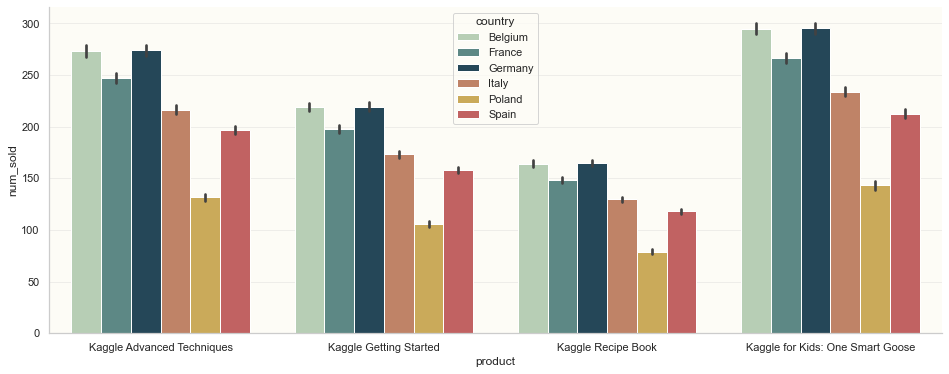

In [4]:
plt.figure(figsize=(16, 6))
ax = sns.barplot(data=train_df, x='product', y='num_sold', hue='country')

**Observation**<br>
- Products have different volumes, use product as feature.
- Belgium and Germany are the ones that sell more, use country as feature.

#### Total sales by country

In [24]:
plt.figure(figsize=(16, 10))
ax = sns.lineplot(
    data = train_df.groupby([
        train_df['date'].dt.strftime('%Y-%m'), train_df['country']
    ])['num_sold'].sum().reset_index(),
    x='date',
    y='num_sold',
    hue='country'
)
ax.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(nbins=20))

#### Date range on Train and Test

In [29]:
train_range = train_df['date'].agg(['min', 'max'])
test_range = test_df['date'].agg(['min', 'max'])

fig, ax = plt.subplots()
ax.plot(train_range, [0.2, 0.2], linewidth=5, marker='.', markersize=20, label='train')
ax.plot(test_range, [0.3, 0.3], linewidth=5, marker='.', markersize=20, label='test', color='red')
ax.set_ylim(0.1, 0.4)
ax.legend()
ax.set_yticks(ticks=[])
plt.xticks(fontsize=14)
ax.legend(borderpad=1.5, fontsize=13)

print('Train', train_range, '\n', sep='\n')
print('Test', train_range , sep='\n')

train
min   2017-01-01
max   2020-12-31
Name: date, dtype: datetime64[ns]


test
min   2017-01-01
max   2020-12-31
Name: date, dtype: datetime64[ns]


**Observation**<br>
- No Overlap between Train and Test.
- Year cannot be used as feature.

#### Check Null Data

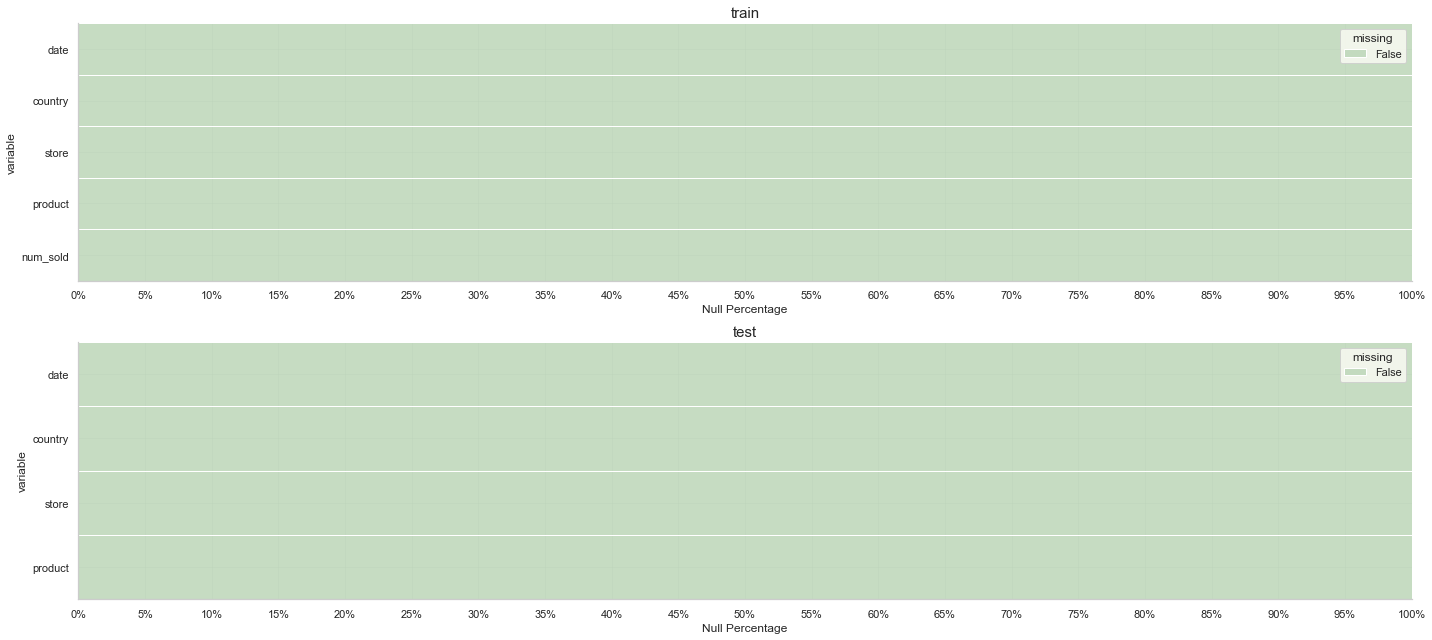

In [31]:
fig = plt.figure(tight_layout=True, figsize=(20, 9))
gs = matplotlib.gridspec.GridSpec(2, 1)
null_table = []

# Plot bars
for i, (k, df) in enumerate({'train':train_df, 'test':test_df}.items()):
    ax = fig.add_subplot(gs[i, 0])
    null_table.append((df.isnull().sum()/df.shape[0]).rename(k))
    
    sns.histplot(
        data=df.drop('Transported', errors='ignore', axis=1).isna().melt(value_name="missing"),
        y="variable",
        hue="missing",
        multiple="fill",
        ax=ax
    )
    ax.xaxis.set_major_locator(matplotlib.ticker.LinearLocator(21))
    ax.xaxis.set_major_formatter('{:.0%}'.format)
    ax.set_title(k, fontsize=15)
    ax.set_xlabel('Null Percentage');

#### Distribution of num_solds

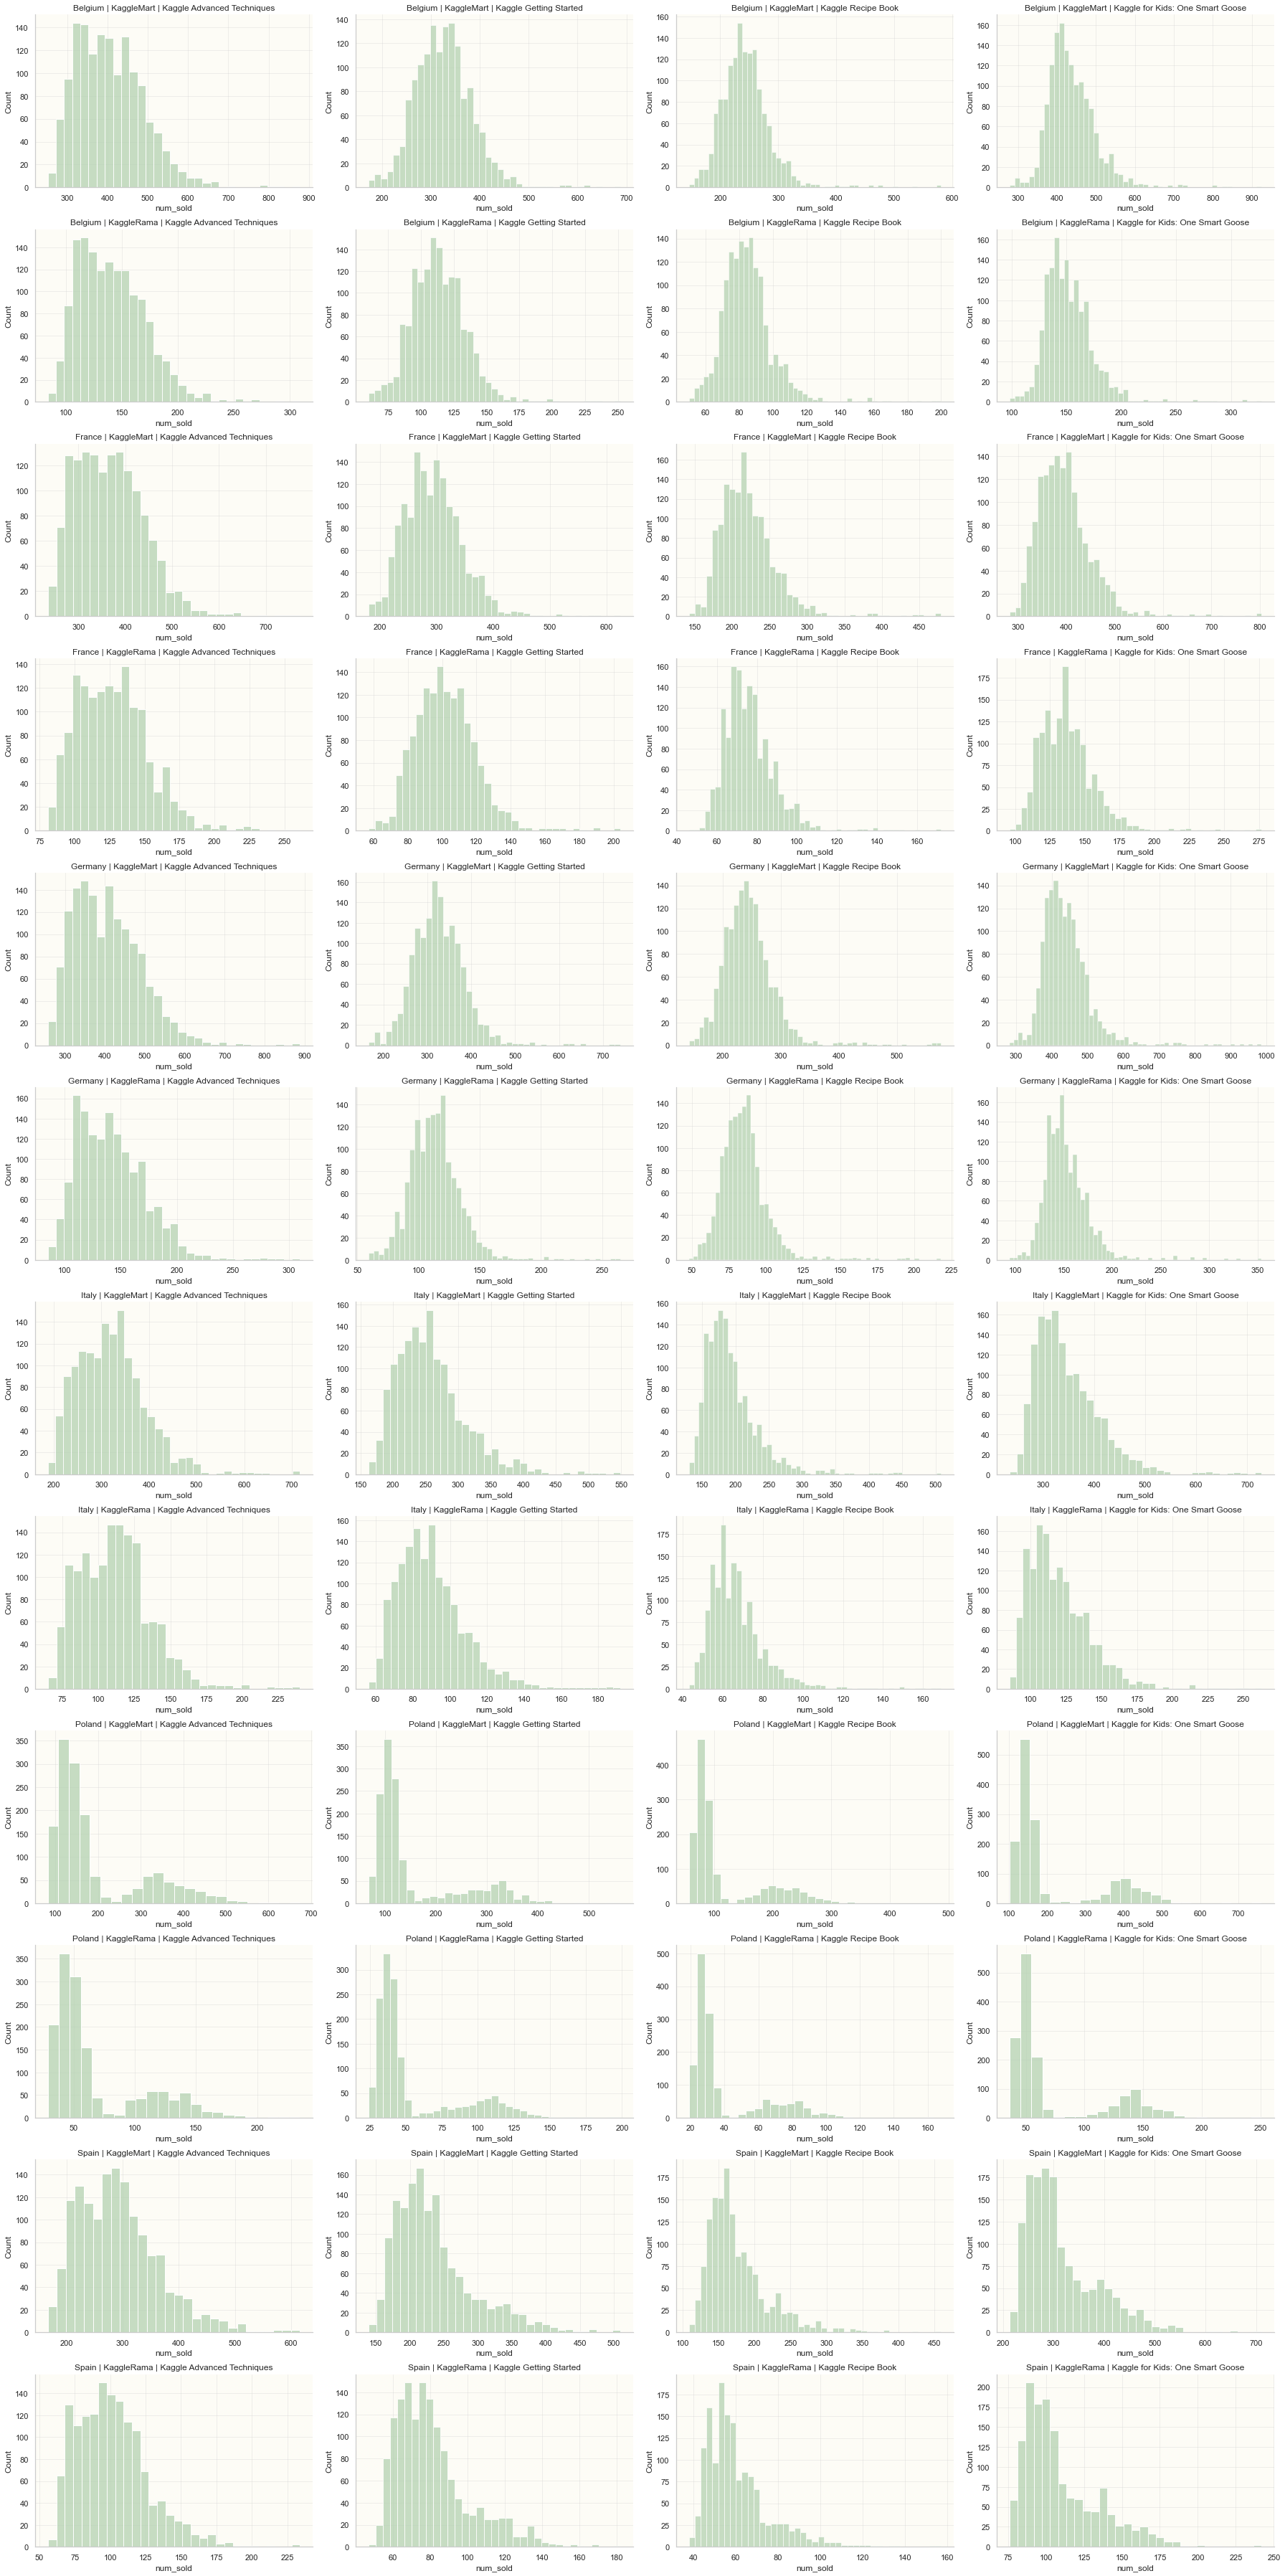

In [33]:
fig, ax = plt.subplots(12, 4, figsize=(25, 50))
ax = ax.flatten()

for i, (combination, df) in enumerate(train_df.groupby(['country', 'store', 'product'])):
    sns.histplot(df['num_sold'], ax=ax[i])
    ax[i].set_title(' | '.join(combination))
plt.tight_layout()

**Observation**<br>
- Distributions are skewed in most cases, SMAPE penalizes more underestimates than overestimates so it choosing a right loss is mandatory.

#### Sells by Product

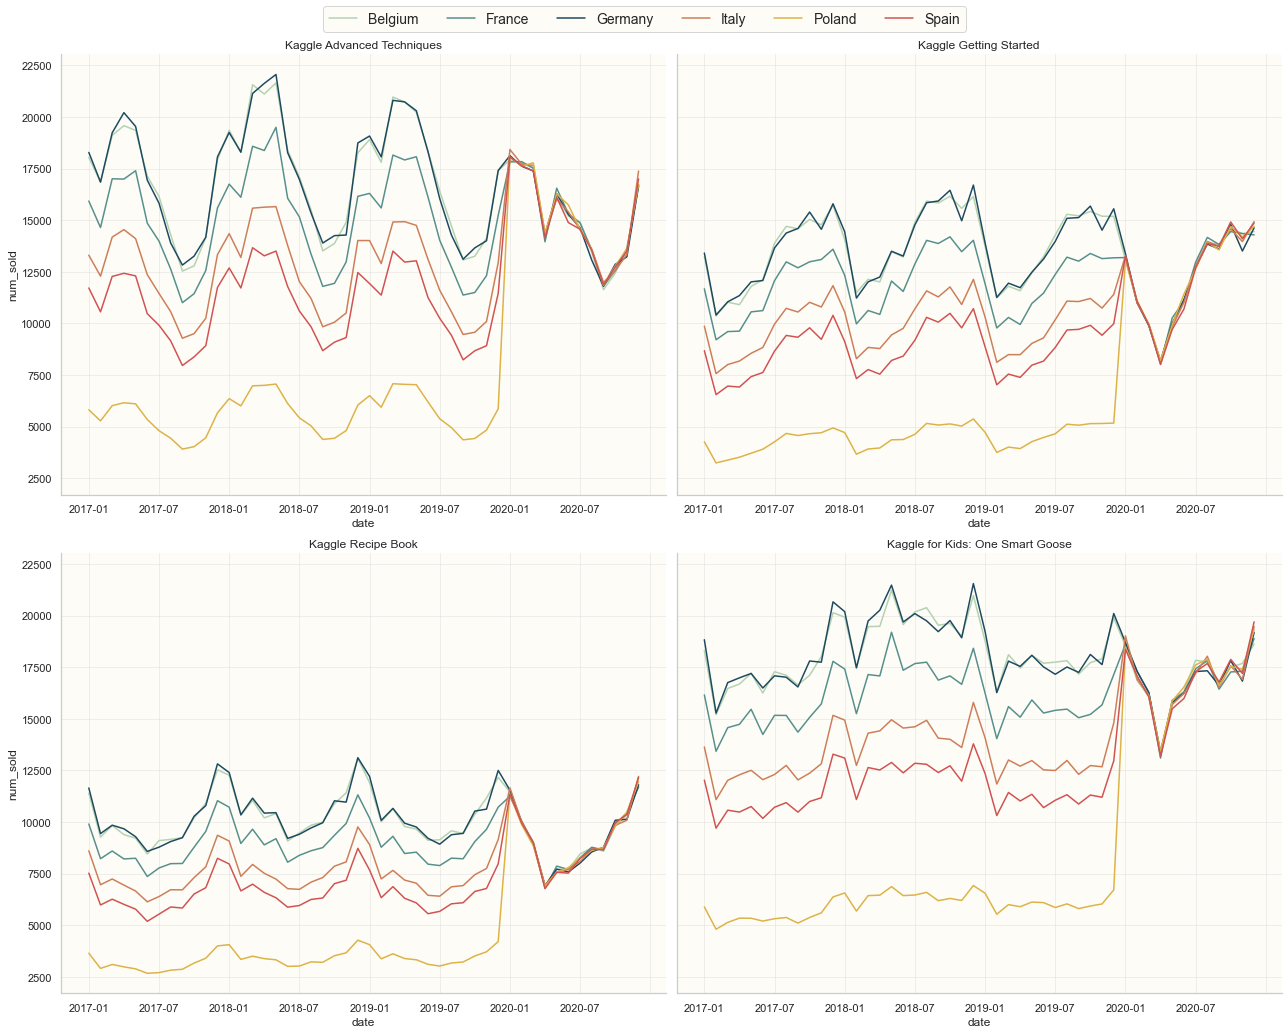

In [45]:
fig, ax = plt.subplots(2, 2, figsize=(18, 14), sharey=True)
ax = ax.flatten()
hue_order = train_df['country'].unique()

for i, product in enumerate(train_df['product'].unique()):
    df = train_df[train_df['product'] == product]
    sns.lineplot(
        data = df.groupby([
            df.date.dt.strftime('%Y-%m'),
            df.country
        ])['num_sold'].sum().reset_index(),
        x='date',
        y='num_sold',
        hue='country',
        ax=ax[i],
        hue_order=hue_order
    )
    ax[i].set_title(product)
    ax[i].xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(nbins=10))
    
    handles = ax[i].get_legend_handles_labels()[0]
    labels = ax[i].get_legend_handles_labels()[1]
    ax[i].legend().remove()
    
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.03) , fontsize=14, ncol=6)
plt.tight_layout()

**Observation**<br>
- All products have that strange behaviour on 2020
- Differences between countries are clear except for Belgium and France.
- Clear month seasonality except on "Kaggle For Kids", probabily good idea to encode the month.

#### Sells by Product and Store

In [52]:
from itertools import product as cartessian_product 
fig, ax = plt.subplots(4, 2, figsize=(18, 20), sharey=True)
ax = ax.flatten()
hue_order = train_df.country.unique()

iterator = cartessian_product(train_df['product'].unique(), train_df['store'].unique())
for i, (product, store) in enumerate(iterator):
    df_plot = train_df[train_df['store'].eq(store) & train_df['product'].eq(product)]
    sns.lineplot(data=df_plot.groupby([
        df_plot.date.dt.strftime('%Y-%m'),
        df_plot.country
    ])['num_sold'].sum().reset_index(),
    x = 'date',
    y = 'num_sold',
    hue='country',
    ax = ax[i],
    hue_order=hue_order
    )
    ax[i].set_title(f'{store} | {product}')
    ax[i].xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(nbins=10))
    
    handles = ax[i].get_legend_handles_labels()[0]
    labels = ax[i].get_legend_handles_labels()[1]
    ax[i].legend().remove()
    
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.03) , fontsize=14, ncol=6)
plt.tight_layout()

**Observation**<br>
- KaggleRama has lower traffic than KaggleMart, store must be a feature.
- Month Seasonality remians.

#### Seasonality

In [4]:
def process_time(df):
    """
    Return different time granularity
    """
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['week'] = df['date'].dt.isocalendar().week
    df.loc[df['week'] > 52, 'week'] = 52
    df['day'] = df['date'].dt.day
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['dayofyear'] = df['date'].dt.dayofyear

process_time(train_df)
process_time(test_df)

def plot_seasonality(season_col, ci=95, alpha=1):
    fig, ax = plt.subplots(4, 2, figsize=(18, 20))
    ax = ax.flatten()
    iterator = cartessian_product(train_df['product'].unique(), train_df['store'].unique())

    for i, (product, store) in enumerate(iterator):
        df_to_plot = train_df[
            train_df.store.eq(store) & 
            train_df['product'].eq(product)
        ]
        sns.lineplot(
            data=pd.melt(
                df_to_plot, id_vars=['country', season_col],
                value_vars=['num_sold'],
                value_name='num_solds'
            ),
            x=season_col,
            y='num_solds',
            hue='country',
            ax=ax[i],
            ci=ci,
            alpha=alpha,
            hue_order=hue_order
        )
        ax[i].set_title(f'{store} | {product}')

        handles = ax[i].get_legend_handles_labels()[0]
        labels = ax[i].get_legend_handles_labels()[1]
        ax[i].legend().remove()

    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.03), fontsize=14, ncol=6)
    plt.suptitle(f'Seasonality by {season_col}', fontsize=16)
    plt.tight_layout()
    return ax

##### DAY

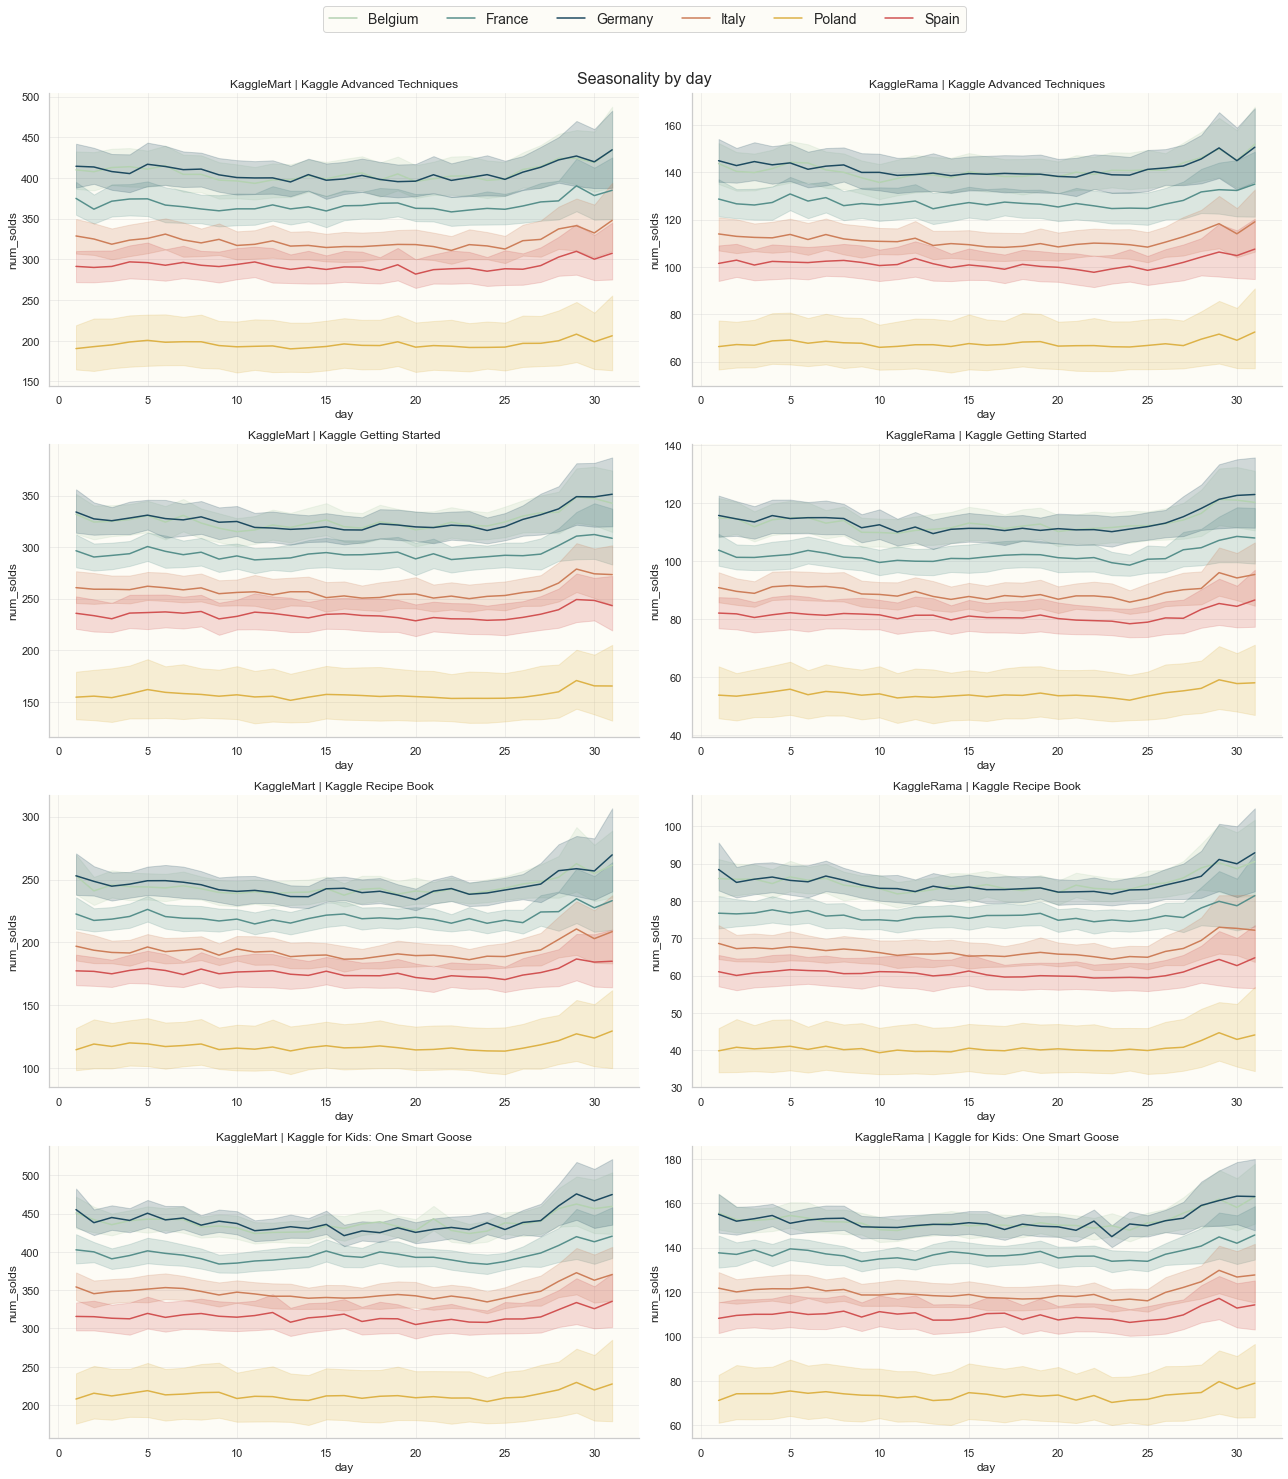

In [70]:
plot_seasonality('day');

**Observation**<br>
- Variability increases by the end of the month. Worth adding a boolean variable `EndOfMonth`.
- Poland is more variable than the other countries, need further invesigation.

In [5]:
train_df['week'] = train_df['week'].astype('int64')
train_df.dtypes

date         datetime64[ns]
country              object
store                object
product              object
num_sold              int64
year                  int64
month                 int64
week                  int64
day                   int64
dayofweek             int64
quarter               int64
dayofyear             int64
dtype: object

In [77]:
plot_seasonality('week');

**Observation**<br>
- Advanced Technique is more popular starting the year, GettingStarted is the other way around.
- Kaggle for Kids is more popular by Xmas same as Kaggle Recipe.

In [71]:
plot_seasonality('month');

**Observation**<br>
- Same as week of the year but Seasonality is more pronounced.

#### Day of week

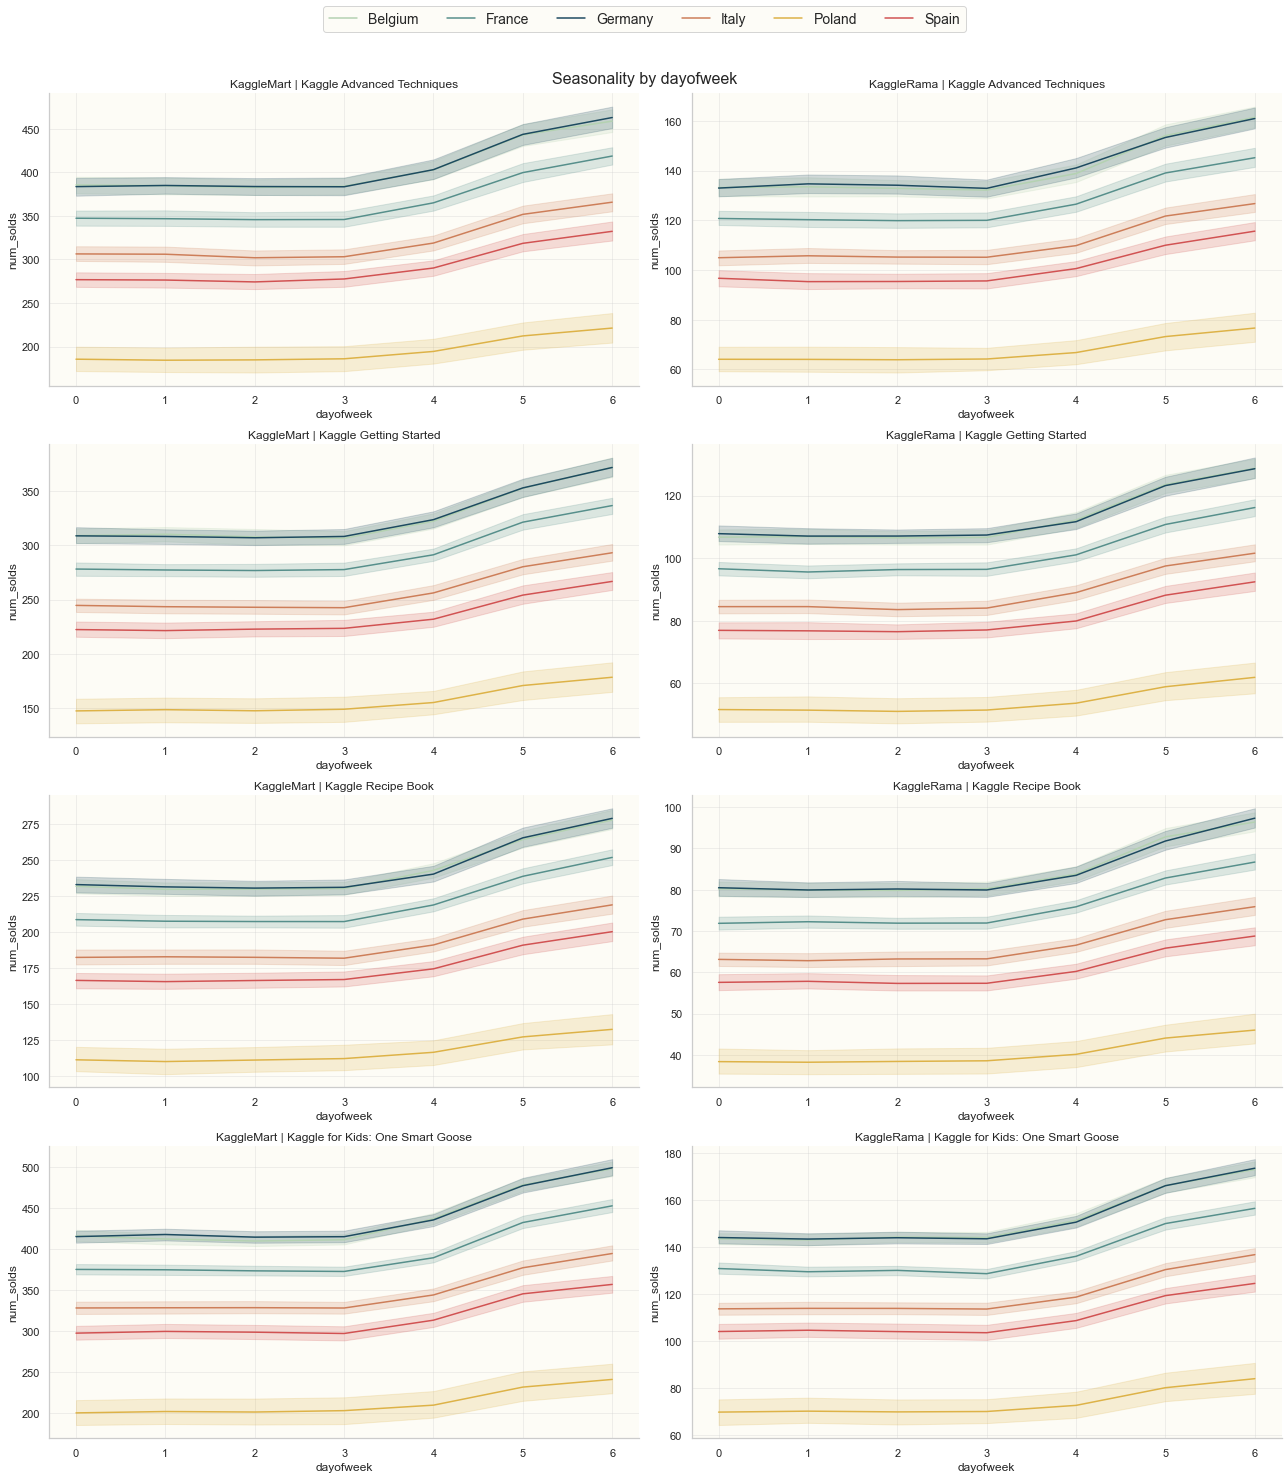

In [82]:
plot_seasonality('dayofweek');

**Observation**<br>
- **Friday, Saturadays and Sundays** are the days where more items are sold, we should create a boolean features `isFriday`, `isSaturday` and `isSunday`.

#### Quater

In [84]:
plot_seasonality('quarter');

array([<AxesSubplot:title={'center':'KaggleMart | Kaggle Advanced Techniques'}, xlabel='quarter', ylabel='num_solds'>,
       <AxesSubplot:title={'center':'KaggleRama | Kaggle Advanced Techniques'}, xlabel='quarter', ylabel='num_solds'>,
       <AxesSubplot:title={'center':'KaggleMart | Kaggle Getting Started'}, xlabel='quarter', ylabel='num_solds'>,
       <AxesSubplot:title={'center':'KaggleRama | Kaggle Getting Started'}, xlabel='quarter', ylabel='num_solds'>,
       <AxesSubplot:title={'center':'KaggleMart | Kaggle Recipe Book'}, xlabel='quarter', ylabel='num_solds'>,
       <AxesSubplot:title={'center':'KaggleRama | Kaggle Recipe Book'}, xlabel='quarter', ylabel='num_solds'>,
       <AxesSubplot:title={'center':'KaggleMart | Kaggle for Kids: One Smart Goose'}, xlabel='quarter', ylabel='num_solds'>,
       <AxesSubplot:title={'center':'KaggleRama | Kaggle for Kids: One Smart Goose'}, xlabel='quarter', ylabel='num_solds'>],
      dtype=object)

- Same as month.

#### Day of Year

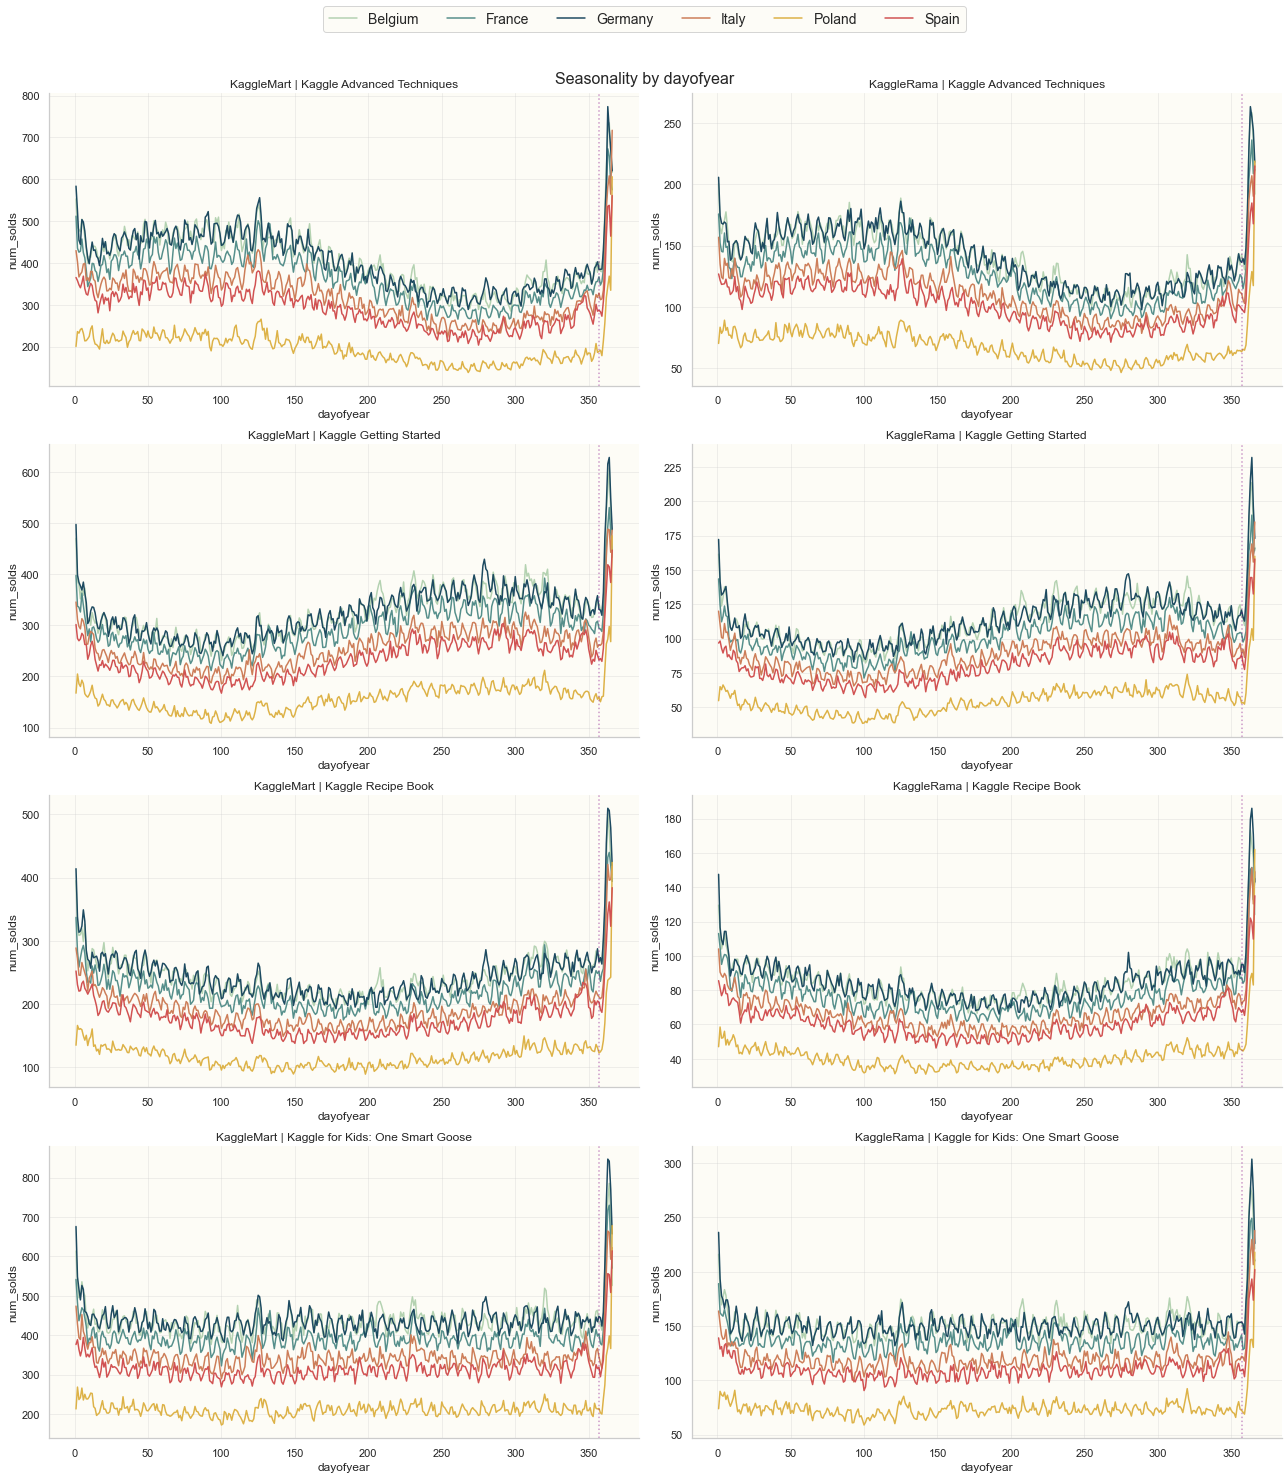

In [86]:
ax = plot_seasonality('dayofyear', ci=None)

for ax_i in ax:
    # 357 = 23 Dec
    ax_i.axvline(357, linestyle=':', color='purple', alpha=0.4)

**Observation**<br>
- Hello end-of-year holidays effects, add boolean features if date is in between Dec24 and Jan1st.

### Feature Engineering

In [6]:
from feature_engine.encoding import OneHotEncoder
import dateutil.easter as easter

def engineer_features(_df):
    df = _df.copy()
    df['friday'] = df.date.dt.weekday.eq(4)
    df['saturday'] = df.date.dt.weekday.eq(5)
    
    # Encode country, store & Product
    print(type(df))
    encoder = OneHotEncoder(variables=['country', 'store', 'product'], drop_last=True)
    df = encoder.fit_transform(df)
    print(type(df))
    df['dayofyear_sin'] = np.sin(df['dayofyear'] / 365 * 2 * np.pi)
    df['dayofyear_cos'] = np.cos(df['dayofyear'] / 365 * 2 * np.pi)
    
    # X-mas holiday indicator
    for day in range(24, 32):
        df[f'dec_{day}'] = df['date'].dt.day.eq(day) & df['date'].dt.month.eq(12)
        
    # Easter Indicator
    ## Get datas surrounding easter and 40 days after
    easter_date = df['date'].apply(lambda date: pd.Timestamp(easter.easter(date.year)))
    for day in list(range(-5, 5)) + list(range(40, 48)):
        df[f'easter_{day}'] = (df['date'] - easter_date).dt.days.eq(day)
        
    df.drop(columns=['date'], inplace=True)
    return df


In [7]:
train_test = engineer_features(train_df.append(test_df))
train_df = train_test.loc[train_df.index].copy()
test_df = train_test.iloc[test_df.index].copy()
test_df.drop(columns=['num_sold'], inplace=True)
target = train_df.pop('num_sold')

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


In [39]:
def smape(y_true, y_pred):
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 200.0
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0.0
    return np.nanmean(diff)

#### Feature Selected

In [15]:
print('features', train_df.columns.tolist())

features ['year', 'month', 'week', 'day', 'dayofweek', 'quarter', 'dayofyear', 'friday', 'saturday', 'country_Belgium', 'country_France', 'country_Germany', 'country_Italy', 'country_Poland', 'store_KaggleMart', 'product_Kaggle Advanced Techniques', 'product_Kaggle Getting Started', 'product_Kaggle Recipe Book', 'dayofyear_sin', 'dayofyear_cos', 'dec_24', 'dec_25', 'dec_26', 'dec_27', 'dec_28', 'dec_29', 'dec_30', 'dec_31', 'easter_-5', 'easter_-4', 'easter_-3', 'easter_-2', 'easter_-1', 'easter_0', 'easter_1', 'easter_2', 'easter_3', 'easter_4', 'easter_40', 'easter_41', 'easter_42', 'easter_43', 'easter_44', 'easter_45', 'easter_46', 'easter_47']


#### Model

#### Linear Regression

In [168]:
linear_model = LinearRegression()
linear_model.fit(train_df, target)
# Creating copy of training and testing dataframe, so we can test more algorithms on them with changing the data in the original datafram
# X_train = train_df.copy() 
# y_train = target.copy()
# X_test = test_df.copy()
# y_test = X_test.drop(columns=['num_sold'], inplace=True)

preds = linear_model.predict(train_df)
print(f'SMAPE: {smape(y_true=target, y_pred=preds):.4f}')

SMAPE: 31.4717


In [112]:
test_preds = linear_model.predict(test_df)
submission = pd.DataFrame({'num_sold':test_preds}, index=test_df.index)
submission.to_csv('submission.csv')

In [173]:
# Combining predicted and actual value to training dataframe to check the prediction.

train_df = pd.concat([train_df, pd.Series(preds, name='predicted_num_sold', index=train_df.index)], axis=1)
train_df = pd.concat([train_df, target], axis=1)

In [175]:
plt.figure(figsize=(14, 10))
sns.lineplot(data=train_df,
             x='month',
             y='num_sold')
sns.lineplot(data=train_df,
             x='month',
             y='predicted_num_sold',
             color='red')

<AxesSubplot:xlabel='month', ylabel='num_sold'>

#### Decision Tree Regressor

In [11]:
model = DecisionTreeRegressor()
model.fit(train_df, target)
preds = model.predict(train_df)
print("R2 Score of Decision Tree is: ", r2_score(target, preds))

R2 Score of Decision Tree is:  1.0


In [12]:
test_preds = model.predict(test_df)
pd.DataFrame({'num_sold':test_preds}, index=test_df.index).to_csv('submission.csv')

In [13]:
# Combining predicted and actual value to training dataframe to check the prediction.

train_df = pd.concat([train_df, pd.Series(preds, name='predicted_num_sold', index=train_df.index)], axis=1)
train_df = pd.concat([train_df, target], axis=1)

In [15]:
test_df = pd.concat([test_df, pd.Series(test_preds, name='num_sold', index=test_df.index)], axis=1)
test_df.head()

year  month  week  day  dayofweek  quarter  dayofyear  friday  \
row_id                                                                  
70128   2021      1    52    1          4        1          1    True   
70129   2021      1    52    1          4        1          1    True   
70130   2021      1    52    1          4        1          1    True   
70131   2021      1    52    1          4        1          1    True   
70132   2021      1    52    1          4        1          1    True   

        saturday  country_Belgium  ...  easter_4  easter_40  easter_41  \
row_id                             ...                                   
70128      False                1  ...     False      False      False   
70129      False                1  ...     False      False      False   
70130      False                1  ...     False      False      False   
70131      False                1  ...     False      False      False   
70132      False                1  ...     False      False      False   

        easter_42  easter_43  easter_44  easter_45  easter_46  easter_47  \
row_id                                                                     
70128       False      False      False      False      False      False   
70129       False      False      False      False      False      False   
70130       False      False      False      False      False      False   
70131       False      False      False      False      False      False   
70132       False      False      False      False      False      False   

        num_sold  
row_id            
70128      501.0  
70129      404.0  
70130      362.0  
70131      536.0  
70132      154.0  

[5 rows x 47 columns]

<AxesSubplot:xlabel='dayofyear', ylabel='num_sold'>

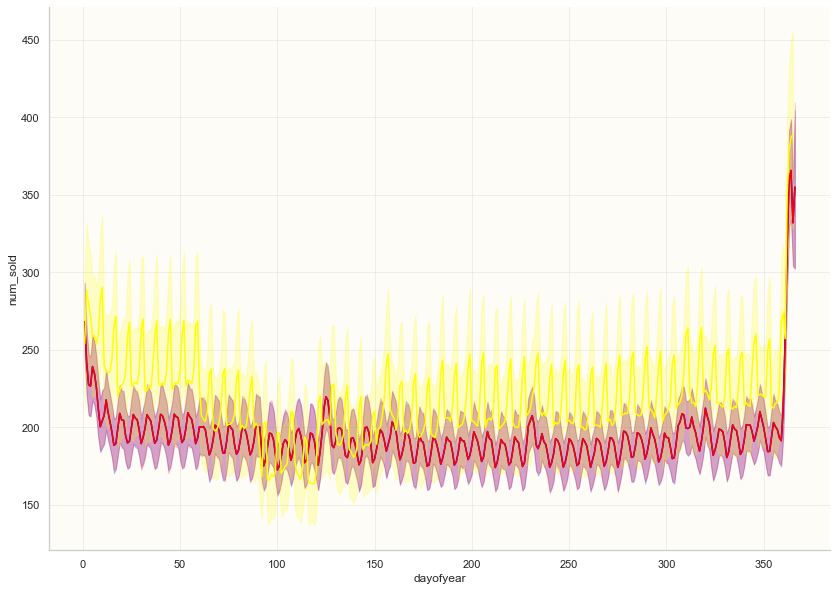

In [18]:
plt.figure(figsize=(14, 10))
sns.lineplot(data=train_df,
             x='dayofyear',
             y='num_sold',
             color='blue')
sns.lineplot(data=train_df,
             x='dayofyear',
             y='predicted_num_sold',
             color='red')

In [ ]:
sns.lineplot(data=test_df)

#### Random Forest Regressor

In [29]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_df, target, test_size=0.3, random_state=5)

rf = RandomForestRegressor()
rf.fit(X_train, y_train)
preds = model.predict(X_test)
print("R2 Score of Random Forest is: ", r2_score(y_test, preds))

R2 Score of Random Forest is:  1.0


In [33]:
test_preds = rf.predict(test_df)
pd.DataFrame({'num_sold':test_preds}, index=test_df.index).to_csv('submission.csv')

#### Xgboost

In [8]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_df, target, test_size=0.3, random_state=5)

model = XGBRegressor()
model.fit(X_train, y_train)
preds = model.predict(X_test)
print("R2 Score of Random Forest is: ", r2_score(y_test, preds))

R2 Score of Random Forest is:  0.9880496750438461


In [9]:
test_preds = model.predict(test_df)
pd.DataFrame({'num_sold':test_preds}, index=test_df.index).to_csv('submission.csv')

In [10]:
regressor = XGBRegressor(base_score=0.5, booster='gblinear', colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=-1, importance_type='gain', interaction_constraints=None,
             learning_rate=0.15, max_delta_step=None, max_depth=15,
             min_child_weight=3, monotone_constraints=None,
             n_estimators=500, n_jobs=16, num_parallel_tree=None,
             random_state=0, reg_alpha=0, reg_lambda=0, scale_pos_weight=1,
             subsample=None, tree_method=None, validate_parameters=1,
             verbosity=None)

regressor.fit(X_train,y_train)
y_pred = regressor.predict(X_test)

from sklearn.metrics import r2_score
print("R2 score:", r2_score(y_test,y_pred, multioutput='variance_weighted'))

[11:10:30] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "max_depth", "min_child_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


R2 score: 0.8062250376497248


In [11]:
n_estimators = [100, 500, 900, 1100, 1500]
max_depth = [2, 3, 5, 10, 15]
learning_rate=[0.05,0.1,0.15,0.20]
min_child_weight=[1,2,3,4]
base_score=[0.25,0.5,0.75,1]

hyperparameter_grid = {
    'n_estimators': n_estimators,
    'max_depth':max_depth,
    'learning_rate':learning_rate,
    'min_child_weight':min_child_weight,
    'base_score':base_score
    }

random_cv = RandomizedSearchCV(estimator=regressor,
            param_distributions=hyperparameter_grid,
            cv=5, n_iter=50,
            scoring = 'neg_mean_absolute_error',n_jobs = 4,
            verbose = 5, 
            return_train_score = True,
            random_state=42)

random_cv.fit(X_train,y_train)

random_cv.best_estimator_

Fitting 5 folds for each of 50 candidates, totalling 250 fits


KeyboardInterrupt: 